# Aging aware training

$$ \min_\theta \quad \int_{t=0}^{1} \; L(\theta(t)) \; dt $$
where  $\theta(t)$ is a fitted model of the conductance over time

## Monte Carlo approximation:

### Introduction

The goal is to integrate the following formular
$$
\int_t f(t){\rm d}t
$$
Rectangular approximation is 
$$
\sum_n f[n\Delta k]\Delta k
$$
The problem is that, if the sampling rate is lower than twice the frequencce of the function, the error would be large, e.g., integrating a $f(t)=\sin(2\pi (t+\frac{1}{4}))$ with sampling rate $\Delta k=1$, i.e.,
$$
\int_tf(t){\rm d}t\approx\sum_n \sin \left(2\pi (n+\frac{1}{4})\right)=n,
$$
which is obviously wrong.

### Monte Carlo Approximation

Recall the definition of **Expectation** of a distribution
$$
\begin{align}
\mathbb{E}\{x\}&=\int_x x\cdot p(x) {\rm d}x\\&\approx \frac{1}{N}\sum_{n=1}^N x_n,\ x_n\sim p(x)
\end{align}
$$
Further, 
$$
\begin{align}
\mathbb{E}\{f(x)\}&=\int_x f(x)\cdot p(x) {\rm d}x\\&\approx \frac{1}{N}\sum_{n=1}^N f(x_n),\ x_n\sim p(x)
\end{align}
$$
For a given integration task $\int_x f(x) {\rm d}x$, we can approximate this by
$$
\int_x f(x) {\rm d}x=\int_x f(x)\cdot 1 {\rm d}x=\int_x f(x)\cdot \frac{p(x)}{p(x)} {\rm d}x=\int_x\frac{f(x)}{p(x)}\cdot p(x) {\rm d}x=\mathbb{E}\left\{\frac{f(x)}{p(x)}\right\}\approx\frac{1}{N}\sum_{n=1}^N \frac{f(x_n)}{p(x_n)},\ x_n\sim p(x)
$$
Let $p(x)$ is a uniform distribution, e.g., $p(x)=\frac{1}{b-a},\ x\in[a,b]$, we have
$$
\int_x f(x) {\rm d}x\approx\frac{1}{N}\sum_{n=1}^N \frac{f(x_n)}{p(x_n)}=\frac{b-a}{N}\sum_{n=1}^N f(x_n),\ x\sim p(x).
$$
Let $b=1$ and $a=0$, 
$$
\int_x f(x) {\rm d}x\approx\frac{1}{N}\sum_{n=1}^N f(x_n),\ x\sim p(x),
$$
i.e., we can approximate the integration by averaging the randomly sampled value $f(x)$, with $x$ following uniform distribution.

Moreover, the method in the introduction is a special case of Monte Carlo method.
## Aging Aware Training

The goal of aging aware training is
$$
\min_{\theta_{\rm init}} \int_{t=0}^1 L(\theta(t)){\rm d}t,
$$
where $\theta(t)=\theta_{\rm init}\cdot\mathop{A}(t)$ denotes the aging of the resistors. Using Monto Carlo method, it is converted to
$$
\min_{\theta_{\rm init}} \frac{1}{K}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right),
$$
where $\mathfrak{K}$ is a set of $K$ uniform randomly sampled timestamps $k\in[0,1]$.

To minimize this function, i.e., $\frac{1}{N}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)$, we apply intuitively the gradient descent:
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{K}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{K}\cdot \sum_{k\in \mathfrak{K} } \nabla_{\theta_{\rm init}}\left(L \left(\theta[k]\right)\right)\\
\end{align}
$$

# Get aging model

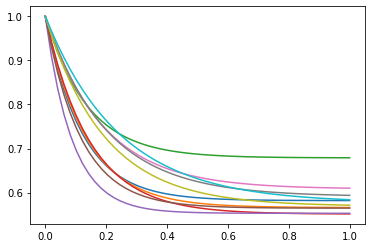

In [1]:
import pickle
import pNN_aging_aware as pnn
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import data
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))
import torch
from torch.autograd import Variable
import torch.nn.functional as F

with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)
vals = np.linspace(0,1)
age_models = age_generator.get_models(10)
for k in age_models:
    plt.plot(vals, k(vals));

## Prepare data

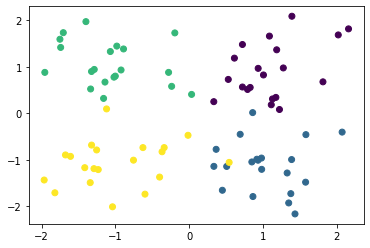

(torch.Size([80, 2]), torch.Size([80]))

In [2]:
X, Y = data.GenerateData(var=0.5, plot=True)
X, Y = X.T, Y.T.flatten()
x, y = torch.from_numpy(X).type(torch.FloatTensor), torch.from_numpy(Y).type(torch.LongTensor)
x, y = Variable(x), Variable(y)
x.shape, y.shape

## Try to get aged theta

In [3]:
import importlib
importlib.reload(pnn)

# generate NN, the initial time, i.e., pnn.PNNLayer.t = 0.
mypnn = torch.nn.Sequential(pnn.PNNLayer(2,5, age_generator),
                            pnn.PNNLayer(5,5, age_generator),
                            pnn.PNNLayer(5,4, age_generator))
counter = 1
for i in mypnn:
    print(f"The {counter}-th layer:")
    counter += 1
    
    print(f"theta at t={i.t}\n", i.theta_aged)    # print theta
    i.t = 0.1         # change time
    print(f"theta at t={i.t}\n", i.theta_aged)    # print aged theta
    
    print("\n")

The 1-th layer:
theta at t=0
 tensor([[7.6169e-01, 9.8075e-01, 8.7810e+00, 3.9568e+01],
        [9.8735e-01, 8.4797e-01, 1.3112e+01, 5.9234e+01],
        [2.4589e-01, 2.6791e-02, 5.5510e+00, 2.5249e+01],
        [5.6468e-01, 3.9450e-01, 1.2154e+01, 5.5257e+01],
        [8.9507e-01, 3.4070e-01, 1.4342e+01, 6.4974e+01]],
       grad_fn=<ViewBackward>)
theta at t=0.1
 tensor([[6.4415e-01, 8.1680e-01, 7.1080e+00, 2.7504e+01],
        [7.7066e-01, 7.1108e-01, 1.0730e+01, 4.6560e+01],
        [2.1329e-01, 2.0472e-02, 4.4087e+00, 2.0176e+01],
        [4.4110e-01, 3.2670e-01, 9.7469e+00, 4.0417e+01],
        [7.4720e-01, 2.6521e-01, 1.1208e+01, 5.1540e+01]],
       grad_fn=<ViewBackward>)


The 2-th layer:
theta at t=0
 tensor([[6.8565e-01, 4.0599e-01, 5.0032e-01, 4.7778e-01, 7.8243e-01, 1.3843e+01,
         6.1507e+01],
        [9.2444e-01, 1.4996e-01, 8.6129e-01, 8.9505e-01, 9.2870e-01, 1.6347e+01,
         7.2251e+01],
        [5.1904e-01, 5.0058e-01, 9.6122e-01, 4.8201e-02, 6.9212e-01, 1.8

# Definations

In [4]:
MyAgedPNN = torch.nn.Sequential(pnn.PNNLayer(2,5, age_generator),
                                pnn.PNNLayer(5,5, age_generator),
                                pnn.PNNLayer(5,4, age_generator))
alpha = 0.001
m = 0.5
T = 0.1
K = 20
optimizer_aged = torch.optim.Adam(MyAgedPNN.parameters(), lr=0.01/K)
MyAgedPNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
  (2): PNNLayer()
)

In [5]:
MyPNN = torch.nn.Sequential(pnn.PNNLayer(2,5, age_generator),
                            pnn.PNNLayer(5,5, age_generator),
                            pnn.PNNLayer(5,4, age_generator))
optimizer = torch.optim.Adam(MyPNN.parameters(), lr=alpha)
MyPNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
  (2): PNNLayer()
)

In [7]:
for s in range(2000):
    optimizer.zero_grad()
    
    prediction = MyPNN(x)
    loss = pnn.LossFunction(prediction, y, m, T)
    loss.backward()
    
    optimizer.step()

    if s % 100 == 0:
        p = torch.max(F.softmax(prediction, dim=0), 1)[1]
        pred_y = p.data.numpy().squeeze()
        acc = sum(pred_y == Y) / Y.shape[0]
        print(f'{s:-6d} |Accuracy: {acc:.5f}\t|Loss: {loss.data:.5f}')
print('Finished.')

     0 |Accuracy: 0.38750	|Loss: 1.08976
   100 |Accuracy: 0.86250	|Loss: 1.04274
   200 |Accuracy: 0.72500	|Loss: 1.02789
   300 |Accuracy: 0.68750	|Loss: 1.01193
   400 |Accuracy: 0.68750	|Loss: 0.99426
   500 |Accuracy: 0.68750	|Loss: 0.97638
   600 |Accuracy: 0.78750	|Loss: 0.95569
   700 |Accuracy: 0.91250	|Loss: 0.92684
   800 |Accuracy: 0.92500	|Loss: 0.88625
   900 |Accuracy: 0.95000	|Loss: 0.81544
  1000 |Accuracy: 0.96250	|Loss: 0.73079
  1100 |Accuracy: 0.96250	|Loss: 0.67071
  1200 |Accuracy: 0.96250	|Loss: 0.63140
  1300 |Accuracy: 0.96250	|Loss: 0.60155
  1400 |Accuracy: 0.96250	|Loss: 0.57812
  1500 |Accuracy: 0.96250	|Loss: 0.55611
  1600 |Accuracy: 0.96250	|Loss: 0.53429
  1700 |Accuracy: 0.95000	|Loss: 0.51199
  1800 |Accuracy: 0.95000	|Loss: 0.48988
  1900 |Accuracy: 0.95000	|Loss: 0.46870
Finished.


In [ ]:
# P = []
# for i in MyPNN:
#     P.append(i.theta_.data)
# for i, j in enumerate(MyAgedPNN):
#     j.theta_ =  torch.nn.Parameter(P[i], requires_grad=True)

In [9]:
for s in range(2000):
    optimizer_aged.zero_grad()
    
    TimeSet = np.random.rand(K)
    for k in TimeSet:
        for i in MyAgedPNN:
            i.t = k
        prediction = MyAgedPNN(x)
        loss = pnn.LossFunction(prediction, y, m, T)
        loss.backward()
    
    optimizer_aged.step()

    if s % 100 == 0:
        avg_loss = 0
        avg_acc = 0
        
        test_time = np.linspace(0,1,100)
        for test_t in test_time:
            for i in MyAgedPNN:
                i.t = test_t
            prediction = MyAgedPNN(x)
            loss = pnn.LossFunction(prediction, y, m, T)
            p = torch.max(F.softmax(prediction, dim=0), 1)[1]
            pred_y = p.data.numpy().squeeze()
            acc = sum(pred_y == Y) / Y.shape[0]

            avg_loss += loss.data
            avg_acc += acc
        
        avg_loss /= 100
        avg_acc /= 100
        
        print(f'{s:-6d} |Accuracy: {avg_acc:.5f}\t|Loss: {avg_loss:.5f}')

print('Finished.')

     0 |Accuracy: 0.59250	|Loss: 1.07497
   100 |Accuracy: 0.61775	|Loss: 1.06084
   200 |Accuracy: 0.65175	|Loss: 1.04377
   300 |Accuracy: 0.68838	|Loss: 1.02793
   400 |Accuracy: 0.71825	|Loss: 1.01271
   500 |Accuracy: 0.73125	|Loss: 0.99835
   600 |Accuracy: 0.74087	|Loss: 0.98453
   700 |Accuracy: 0.76175	|Loss: 0.97133
   800 |Accuracy: 0.76650	|Loss: 0.95871
   900 |Accuracy: 0.78625	|Loss: 0.94739
  1000 |Accuracy: 0.79900	|Loss: 0.93728
  1100 |Accuracy: 0.82463	|Loss: 0.92767
  1200 |Accuracy: 0.85525	|Loss: 0.91792
  1300 |Accuracy: 0.86375	|Loss: 0.90767
  1400 |Accuracy: 0.86987	|Loss: 0.89671
  1500 |Accuracy: 0.87825	|Loss: 0.88728
  1600 |Accuracy: 0.88813	|Loss: 0.87839
  1700 |Accuracy: 0.89538	|Loss: 0.86972
  1800 |Accuracy: 0.91137	|Loss: 0.86089
  1900 |Accuracy: 0.92350	|Loss: 0.85180
Finished.


In [ ]:
import evaluation
import importlib
importlib.reload(evaluation)

test_time = np.linspace(0,1,100)
my_aged_acc = []
my_acc = []
my_aged_maa = []
my_maa = []

for test_t in test_time:
    for i in MyAgedPNN:
        i.t = test_t
    for i in MyPNN:
        i.t = test_t
    
    my_aged_acc.append(evaluation.basic(MyAgedPNN, x, y))
    my_acc.append(evaluation.basic(MyPNN, x, y))
    
    my_aged_maa.append(evaluation.maa(MyAgedPNN, x, y))
    my_maa.append(evaluation.maa(MyPNN, x, y))

In [ ]:
plt.plot(test_time, my_aged_acc, label='aging_aware');
plt.plot(test_time, my_acc, label='previous');
plt.xlabel('normalized time');
plt.ylabel('basic accuracy');
plt.xlim([0, 1])
plt.legend();

In [ ]:
plt.plot(test_time, my_aged_maa, label='aging_aware');
plt.plot(test_time, my_maa, label='previous');
plt.xlabel('normalized time');
plt.ylabel('measure aware accuracy');
plt.xlim([0, 1])
plt.legend();